# Earth at Night in HD: Predicting High-Resolutions Nighttime Radiance from Daytime Satellite Imagery
Isaiah Lyons-Galante  
University of Colorado Boulder   
CSCI 5922 Neural Networks and Deep Learning  
Final Project  
Fall 2023  

![earth at night](./figs/earthatnight.png)



# Introduction

The imprint of human activity on Earth has become unmistakable, offering a unique vantage point for population studies through the lens of space. Access to global high-resolution datasets, such as Landsat(1), has been made possible for the public through platforms like Google Earth Engine (3). These datasets open a window to observe and analyze human settlements, providing invaluable insights into the dynamics of our changing world. The image below is from Google Earth, showing the twin cities of Brazzaville and Kishasa on the banks of the Congo River. One can clearly see the densely package settlements on the banks, along with the unpopulated islands in the river.

![brazzaville](./figs/brazzaville.png)

During the night, human presence becomes even more apparent as settlements cast a faint glow into space. This nocturnal illumination is captured by the VIIRS instrument aboard the Suomi National Polar-orbiting Partnership (NPP) satellite. Despite its significance, the relatively weak signals limit the resolution to about 500 meters squared. This limitation poses a challenge to extracting fine-grained information about the distribution and characteristics of human settlements. The image below is of the same area as the one above, but at night. The resolution is significantly lower, with the pixels clearly visible, while the island in the river is completely dark.

![brazzaville night](./figs/brazzavilleatnight.png)

Compelling research underscores the correlation between night lights and mean household wealth, as measured by ground surveys. This correlation establishes night lights as a proxy for gauging livelihoods, making them a valuable tool for socio-economic analyses. This becomes particularly crucial in regions like Sub-Saharan Africa, where traditional population surveys are sparse. The scarcity of on-the-ground data highlights the potential of night lights as a surrogate measure for understanding the economic landscapes of communities. The graph below shows the relationship between night lights and mean household wealth in Sub-Saharan Africa. The data is from the Demographic and Health Surveys (DHS) Program, which conducts household surveys in developing countries. The graph shows a clear correlation between night lights and mean household wealth.

![night lights and wealth](./figs/wealthcorrelations.jpg)

The demand for higher-resolution night lights becomes evident when considering the need for detailed impact assessments. Such assessments can unravel the intricate ways in which individual communities are affected by economic development programs or global events. As technology advances, the quest for sharper and more detailed night light data gains significance, promising to enhance our understanding of human settlements and socio-economic patterns on a global scale. One example of this comes from a paper in Nature just last year that use wealth maps to assess the economic impact of access to electricity. High resolution nightlights would open up even finer grained analysis.

![wealth map](./figs/WealthMap.png)

Embarking on this exploration of human settlements and socio-economic patterns, I employ cutting-edge methodologies to surmount the resolution challenges posed by existing night light data. Leveraging the power of machine learning, my approach involves training a model to predict night lights from high-resolution daytime imagery. By undertaking this innovative process, I aim to transcend the limitations of the existing data and generate high-resolution nighttime imagery. This fusion of technological advancements with geospatial analysis not only promises to enrich our understanding of human settlements but also sets the stage for a more nuanced examination of the impact of economic development programs and global events on individual communities. This notebook will serve as a guide for the entire process, from method design to model training and evaluation, and finally, the results and conclusions. 



# Methods

Goal: 




 output is VIIRS Day/Night Band from [VIIRS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) and the input is a Landsat 8 composite.  The model is a [fully convolutional neural network (FCNN)](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf), specifically [U-net](https://arxiv.org/abs/1505.04597). In this notebook, we:

1.   Export train/test patches from Earth Engine, suitable for training an FCNN model.
2.   Preprocess the data. 
3.   Train and validating an FCNN model.
4.   Maki predictions with the trained model and import them to Earth Engine.

# Setup software libraries

Authenticate and import as necessary.

In [1]:
# Read in the .env file
from dotenv import dotenv_values, load_dotenv

# load env variables
config = dotenv_values(".env")
load_dotenv()

# set env variables
GCS_PROJECT = config['GCS_PROJECT']
BUCKET = config['BUCKET']
HOME_PATH = config['HOME_PATH']
LOCAL_PATH = config['LOCAL_PATH']
DATA_PATH = config['DATA_PATH']
FOLDER = config['FOLDER']
GCLOUD_PATH = config['GCLOUD_PATH']
CUDA_VISIBLE_DEVICES = config['CUDA_VISIBLE_DEVICES']

print(config)


OrderedDict([('GCS_PROJECT', 'master-thesis-ilg'), ('BUCKET', 'csci5922-proj'), ('HOME_PATH', '/home/isly9493/'), ('LOCAL_PATH', '/local/isly9493/'), ('DATA_PATH', 'csci5922/proj/data/'), ('FOLDER', 'viirs-africa-many/'), ('GCLOUD_PATH', '/home/isly9493/google-cloud-sdk/bin/'), ('CUDA_VISIBLE_DEVICES', '1')])


In [3]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)
# Folium setup.
import folium
print(folium.__version__)

2.15.0
0.15.1


# Variables

Declare the variables that will be in use throughout the notebook.

## Specify your Cloud Storage Bucket
You must have write access to a bucket to run this notebook

## Set other global variables

In [5]:
# variables for image names
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'avg_rad' ##### 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 4800 # orignally 16000, use 800 for small version, 8000 for medium version
EVAL_SIZE = 200 # originally 8000, use 200 for small version

# Specify model training parameters.
BATCH_SIZE = 48 # orignally 16
EPOCHS = 20 # originally 10
BUFFER_SIZE = 2000 # originally 2000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

# Create and Stack Input + Target Imagery

Gather and setup the imagery to use for inputs (predictors).  This is a three-year, cloud-free, Landsat 8 composite.  Display it in the notebook for a sanity check.

In [6]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
          image.select(thermalBands).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2020-01-01', '2022-12-31').map(maskL8sr).median()

# printn out the bands
print(image.bandNames().getInfo())

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[-1, 37], zoom_start=6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

mapid = image.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11']


Prepare the response (what we want to predict).  This is nighttime brightness (in nanoWatts/sr/cm^2) from the VIIRS dataset.  Display to check.

In [7]:
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2020-01-01', '2022-12-31').median()
viirs = viirs.divide(2).float() # normalize to 0-1 range

mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
map = folium.Map(location=[-1, 37], zoom_start=6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Stack the 2D images (Landsat composite and VIIRS DNB image) to create a single image from which samples can be taken.  Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band.  This is a key step that bears emphasis: to export training patches, convert a multi-band image to [an array image](https://developers.google.com/earth-engine/arrays_array_images#array-images) using [`neighborhoodToArray()`](https://developers.google.com/earth-engine/api_docs#eeimageneighborhoodtoarray), then sample the image at points.

In [8]:
featureStack = ee.Image.cat([
  image.select(BANDS),
  viirs.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

# Define Training and Evaluation Areas
Use some pre-made geometries to sample the stack in strategic locations.  Specifically, these are hand-made polygons in which to take the 256x256 samples.  Display the sampling polygons on a map, red for training polygons, blue for evaluation.

In [9]:
# trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
# evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')
# # trainingPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/trainingPolys')
# # evalPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/evalPolys')
# trainingPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/trainingPolysAfrica')
# evalPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/evalPolysAfrica')
trainingPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/trainingPolysAfricaBig')
evalPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/evalPolysAfrica')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['gold', 'blue']})
map = folium.Map(location=[0, 12], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

# Sampling

The mapped data look reasonable so take a sample from each polygon and merge the results into a single export.  The key step is sampling the array image at points, to get all the pixels in a 256x256 neighborhood at each point.  It's worth noting that to build the training and testing data for the FCNN, you export a single TFRecord file that contains patches of pixel values in each record.  You do NOT need to export each training/testing patch to a different image.  Since each record potentially contains a lot of data (especially with big patches or many input bands), some manual sharding of the computation is necessary to avoid the `computed value too large` error.  Specifically, the following code takes multiple (smaller) samples within each geometry, merging the results to get a single export.

In [11]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 20 # Number of shards in each polygon. # originally 200
N = 200 # Total sample size in each polygon. # orignally 2000


# Export Training & Evaluation Data from Earth Engine to Google Cloud Storage
This can be modified to export to local storage, just adjust the file paths.

In [12]:

# Export all the training data (in many pieces), with one task
# per geometry.
for g in range(trainingPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(trainingPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n, # Size of the shard.
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)
  
  desc = TRAINING_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Training imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

0 viirs-africa-many/ csci5922-proj training_patches_g0
1 viirs-africa-many/ csci5922-proj training_patches_g1
2 viirs-africa-many/ csci5922-proj training_patches_g2
3 viirs-africa-many/ csci5922-proj training_patches_g3
4 viirs-africa-many/ csci5922-proj training_patches_g4
5 viirs-africa-many/ csci5922-proj training_patches_g5
6 viirs-africa-many/ csci5922-proj training_patches_g6
7 viirs-africa-many/ csci5922-proj training_patches_g7
8 viirs-africa-many/ csci5922-proj training_patches_g8
9 viirs-africa-many/ csci5922-proj training_patches_g9
10 viirs-africa-many/ csci5922-proj training_patches_g10
11 viirs-africa-many/ csci5922-proj training_patches_g11
12 viirs-africa-many/ csci5922-proj training_patches_g12
13 viirs-africa-many/ csci5922-proj training_patches_g13
14 viirs-africa-many/ csci5922-proj training_patches_g14
15 viirs-africa-many/ csci5922-proj training_patches_g15
16 viirs-africa-many/ csci5922-proj training_patches_g16
17 viirs-africa-many/ csci5922-proj training_patche

In [13]:

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(evalPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n,
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  desc = EVAL_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Eval imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

0 viirs-africa-many/ csci5922-proj eval_patches_g0
1 viirs-africa-many/ csci5922-proj eval_patches_g1
Eval imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).


# Copy Files from Google Cloud Storage to Local Storage
This is necessary to run the model locally.

In [ ]:

# Copy from your bucket to local path (note -r is for recursive call)
# !{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{TRAINING_BASE}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}
# !{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{EVAL_BASE}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}

!{GCLOUD_PATH}gsutil cp 'gs://csci5922-proj/viirs-africa-big/training_patches_g23.tfrecord.gz' {LOCAL_PATH}{DATA_PATH}{FOLDER}

# Configure GPU Usage

Depending on how many GPUs are needed.

In [ ]:
# see what devices are available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
!nvidia-smi
# tf.debugging.set_log_device_placement(False)


In [ ]:
# configure the strategy to use all GPUs
# gpus = tf.config.list_logical_devices('GPU')
# gpu_strategy = tf.distribute.MirroredStrategy(gpus)

# gpu_strategy = tf.device('/GPU:1')

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"


# Training and Evaluation Data

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [ ]:
# from google.cloud import storage

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(path, prefix, n_files):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  # original code
  # glob = tf.io.gfile.glob(pattern)
  
  # from the cloud
  # https://cloud.google.com/appengine/docs/legacy/standard/python/googlecloudstorageclient/read-write-to-cloud-storage
  # storage_client = storage.Client()
  # bucket = storage_client.get_bucket(BUCKET)
  # blobs = storage_client.list_blobs(BUCKET, prefix=pattern)
  # glob = []
  # for blob in blobs:
  #   globs.append(blob.name)
  # print(globs)
  # # append bucket name to globs
  # glob = ['gs://' + BUCKET + '/' + f for f in globs]

  # read local tfrecord.gz files from unet-mini
  glob = []
  for i in range(0, n_files):
    glob = path + prefix + '_g' + str(i) + '.tfrecord.gz'

  # glob = [
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g0.tfrecord.gz',
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g1.tfrecord.gz'
  # ]
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset


Use the helpers to read in the training dataset.  Print the first record to check.

In [ ]:
# with tf.device('/GPU:1'):
# with gpu_strategy.scope():
training = get_dataset(LOCAL_PATH + DATA_PATH + FOLDER, TRAINING_BASE, 24)
training = training.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# print(iter(training.take(1)).next())

# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

In [ ]:
# with tf.device('/GPU:1')
# with gpu_strategy.scope():
evaluation = get_dataset(LOCAL_PATH + DATA_PATH + FOLDER, EVAL_BASE, 2)
evaluation = evaluation.batch(1).repeat()
# print(iter(evaluation.take(1)).next()[0][0,:,:,1:3])


In [ ]:
# visualize of the of the training / evaluation image patch pairs
import numpy as np
import matplotlib.pyplot as plt

# # Display a batch of data
def display_batch_of_images(databatch):
    """Display a batch of images.
    Args:
        databatch: A batch of data
    """
    imgs, labels = databatch
    
    # show landsat in RGD with blue as band 2, green as band 3, and red as band 4
    plt.figure(figsize=(10,10))
    label = labels.numpy().astype(np.float32)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[i,:,:,2:5]*6)
        # plt.imshow(tf.concat([
        #     imgs[i,:,:,4],
        #     imgs[i,:,:,3],
        #     imgs[i,:,:,2]
        # ]))
        # plt.title('LandSat 8')
        plt.axis('off')
    plt.show()
    # show viirs in grayscale
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(labels[i,:,:,0], cmap='gray')
        # plt.title('VIIRS DNB')
        plt.axis('off')
    plt.show()

# Display a batch of data
display_batch_of_images(iter(training.take(1)).next())
# display_batch_of_images(iter(evaluation.take(1)).next())



# Model

Here we use the Keras implementation of the U-Net model.  The U-Net model takes 256x256 pixel patches as input and outputs per-pixel class probability, label or a continuous output.  We can implement the model essentially unmodified, but will use mean squared error loss on the sigmoidal output since we are treating this as a regression problem, rather than a classification problem.  Since impervious surface fraction is constrained to [0,1], with many values close to zero or one, a saturating activation function is suitable here.

In [ ]:
from tensorflow import keras
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder


def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])
	
	# set optimizer with custom learning rate
	OPTIMIZER = 'SGD'
	optimizer = optimizers.get(OPTIMIZER)
	# optimizer.learning_rate = 0.1

	# compile the model
	model.compile(
		optimizer=optimizer,
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

# Training the model

You train a Keras model by calling `.fit()` on it.  Here we're going to train for 10 epochs, which is suitable for demonstration purposes.  For production use, you probably want to optimize this parameter, for example through [hyperparamter tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning).

In [ ]:
# print the current time
from datetime import datetime
print(datetime.now())

# with tf.device('/GPU:1')
# with gpu_strategy.scope():
m = get_model()
history = m.fit(
    x=training,
    epochs=20,
    # steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    steps_per_epoch=1000,
    validation_data=evaluation,
    validation_steps=EVAL_SIZE
)

print(datetime.now())

In [16]:
MODEL_NAME = 'viirs_africa_big_e20_tiny_batch.keras'
HISTORY_NAME = 'viirs_africa_big_e20_tiny_batch_history.pickle'
ASSET_SUFFIX = 'viirs_africa_big_e20_tiny_batch' 
EPOCHS = 20

In [ ]:
# save the model to a local file 
m.save(LOCAL_PATH + DATA_PATH + FOLDER + MODEL_NAME)
# m.save(MODEL_NAME)

# # save the history variable to a local file with pickle
import pickle
with open(LOCAL_PATH + DATA_PATH + FOLDER + HISTORY_NAME, 'wb') as f:
# with open(HISTORY_NAME, 'wb') as f:
  pickle.dump(history, f)
# issue: doesn't save the history field of the history object

Note that the notebook VM is sometimes not heavy-duty enough to get through a whole training job, especially if you have a large buffer size or a large number of epochs.  You can still use this notebook for training, but may need to set up an alternative VM ([learn more](https://research.google.com/colaboratory/local-runtimes.html)) for production use.  Alternatively, you can package your code for running large training jobs on Google's AI Platform [as described here](https://cloud.google.com/ml-engine/docs/tensorflow/trainer-considerations).  The following code loads a pre-trained model, which you can use for predictions right away.

In [14]:
# MODEL_DIR = 'gs://ee-docs-demos/fcnn-demo/trainer/model'
# m = tf.keras.models.load_model('/local/isly9493/csci5922/proj/data/viirs-africa/unet_viirs_e50.keras')
# m = tf.keras.models.load_model(MODEL_NAME)
# m.summary()

# # load the history variable from a local file with pickle
import pickle
# with open(HISTORY_NAME, 'rb') as f:
with open('/local/isly9493/csci5922/proj/data/viirs-africa-big/viirs_africa_big_e20_tiny_batch_history.pickle', 'rb') as f:
  history = pickle.load(f)

2023-12-12 14:27:30.350520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 14:27:30.372188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 14:27:30.372377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Evaluation
Let's look at how the model performed in terms of loss while it trained.

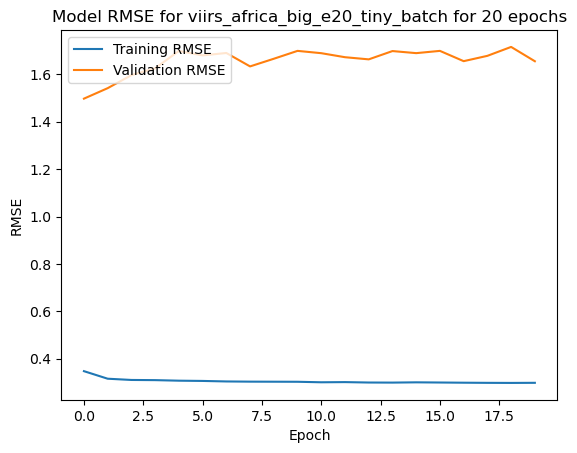

In [17]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE for ' + ASSET_SUFFIX + ' for ' + str(EPOCHS) + ' epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Training RMSE', 'Validation RMSE'], loc='upper left')
plt.show()

In [ ]:
## evaluate the model on the evaluation dataset to get the loss and RMSE
loss, rmse = m.evaluate(evaluation, steps=EVAL_SIZE)
print('Model loss: {:0.4f}. RMSE: {:0.4f}'.format(loss, rmse))

In [ ]:
loss, rmse = m.evaluate(training, steps=10)
print('Model loss: {:0.4f}. RMSE: {:0.4f}'.format(loss, rmse))

# Prediction

The prediction pipeline is:

1.  Export imagery on which to do predictions from Earth Engine in TFRecord format to a Cloud Storage bucket.
2.  Use the trained model to make the predictions.
3.  Write the predictions to a TFRecord file in a Cloud Storage.
4.  Upload the predictions TFRecord file to Earth Engine.

The following functions handle this process.  It's useful to separate the export from the predictions so that you can experiment with different models without running the export every time.

### Specify Region and Outputs for Prediction

In [ ]:
# Output assets folder: YOUR FOLDER
ee_user_folder = 'projects/'+GCS_PROJECT+'/assets' # INSERT YOUR FOLDER HERE.

# # Base file name to use for TFRecord files and assets.
# pred_image_base = 'FCNN_demo_beijing_384_'
# # Half this will extend on the sides of each patch.
# pred_kernel_buffer = [128, 128]
# # Beijing
# pred_region = ee.Geometry.Polygon(
#         [[[115.9662455210937, 40.121362012835235],
#           [115.9662455210937, 39.64293313749715],
#           [117.01818643906245, 39.64293313749715],
#           [117.01818643906245, 40.121362012835235]]], None, False)

# kinshasa center: 15.267681, -4.286977
pred_image_base = 'FCNN_demo_kinshasa_384_'
# Half this will extend on the sides of each patch.
pred_kernel_buffer = [128, 128]
# Kinshasa
pred_region = ee.Geometry.Polygon(
  [[[15.02, -4.04],
    [15.02, -4.54],
    [15.52, -4.54],
    [15.52, -4.04]]], 
  None, 
  False
)

### Export Sample Imagery for Prediction

In [ ]:
def doExport(out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(BANDS),
    description = out_image_base,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + out_image_base,
    region = region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()
  print('Prediction image export task submitted. Check on the task in GEE for its status (https://code.earthengine.google.com/tasks).')

  # Block until the task completes.
  # import time
  # while task.active():
  #   time.sleep(30)

  # Error condition
  # if task.status()['state'] != 'COMPLETED':
  #   print('Error with image export.')
  # else:
  #   print('Image export completed.')

In [ ]:
# Run the export.
doExport(pred_image_base, pred_kernel_buffer, pred_region)

In [ ]:
# copy the file from cloud storage to local
# !{GCLOUD_PATH}gsutil -m cp \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'00000.tfrecord.gz' \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'00001.tfrecord.gz' \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'00002.tfrecord.gz' \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'00003.tfrecord.gz' \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'00004.tfrecord.gz' \
#   'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'mixer.json' \
#   {LOCAL_PATH}{DATA_PATH}{FOLDER}

# !{GCLOUD_PATH}gsutil -m cp -r 'gs://csci5922-proj/viirs-africa/FCNN_demo_kinshasa*' 'gs://csci5922-proj/viirs-africa-small/'

!{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}

### Define Code for Running Model on Prediction Data
Modified to run on local data.

In [ ]:
def doPrediction(out_image_base, kernel_buffer):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # # Get a list of all the files in the output bucket.
  # filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}
  # Get a list of all local files in /data/unet-mini
  filesList = !ls {LOCAL_PATH}{DATA_PATH}{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print('here I am')
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  # jsonText = !{GCLOUD_PATH}gsutil cat {jsonFile}  
  # jsonText = !cat '/home/isly9493/csci5922/proj/data/viirs-usa/FCNN_demo_beijing_384_mixer.json'
  jsonText = !cat {LOCAL_PATH}{DATA_PATH}{FOLDER}{jsonFile}
  print(jsonText)
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']



  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # append absolute path to imageFilesList
  imageFilesList = [LOCAL_PATH + DATA_PATH + FOLDER + f for f in imageFilesList]
  print(imageFilesList)
  
  # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # print(imageDataset)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])
  return predictions

In [ ]:

def writePredictions(predictions, out_image_base, kernel_buffer):
  print('Writing predictions...')
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'
  # out_image_file = LOCAL_PATH + DATA_PATH + FOLDER + out_image_base + '.TFRecord'

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)
  
  
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
  for predictionPatch in predictions:
    # print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
            float_list=tf.train.FloatList(
              value=predictionPatch.flatten()
            )
          )
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  print('Done writing predictions.')
  writer.close()


In [ ]:
def uploadPredictionsToEE(out_image_base, ee_user_folder):
  # Start the upload.
  print('Uploading to Google Earth Egnine...')
  
  # define file paths
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'
  out_image_asset = ee_user_folder + '/' + out_image_base + ASSET_SUFFIX
  jsonFile = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + 'mixer.json'
  # jsonFile = '/home/isly9493/csci5922/proj/data/unet-mini/FCNN_demo_beijing_384_mixer.json'
  
  print('out_image_asset: ', out_image_asset)
  print('out_image_file: ', out_image_file)
  print('jsonFile: ', jsonFile)
  
  # upload file to google earth engine from gcs
  # !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

  print('Prediction image upload task submitted. Check on the task in GEE for its status (https://code.earthengine.google.com/tasks).')

In [ ]:
# copy over prediction files
# !{GCLOUD_PATH}gsutil -m cp \
#   "gs://csci5922-proj/viirs-africa-small/FCNN_demo_kinshasa_384_.TFRecord" \
#   "gs://csci5922-proj/viirs-africa-small/FCNN_demo_kinshasa_384_00000.tfrecord.gz" \
#   "gs://csci5922-proj/viirs-africa-small/FCNN_demo_kinshasa_384_00001.tfrecord.gz" \
#   "gs://csci5922-proj/viirs-africa-small/FCNN_demo_kinshasa_384_00002.tfrecord.gz" \
#   "gs://csci5922-proj/viirs-africa-small/FCNN_demo_kinshasa_384_mixer.json" \
#   "gs://csci5922-proj/viirs-africa-big/"

Now there's all the code needed to run the prediction pipeline, all that remains is to specify the output region in which to do the prediction, the names of the output files, where to put them, and the shape of the outputs.  In terms of the shape, the model is trained on 256x256 patches, but can work (in theory) on any patch that's big enough with even dimensions ([reference](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)).  Because of tile boundary artifacts, give the model slightly larger patches for prediction, then clip out the middle 256x256 patch.  This is controlled with a kernel buffer, half the size of which will extend beyond the kernel buffer.  For example, specifying a 128x128 kernel will append 64 pixels on each side of the patch, to ensure that the pixels in the output are taken from inputs completely covered by the kernel.

### Run Predictions

In [ ]:
# Run the prediction.
predictions = doPrediction(pred_image_base, pred_kernel_buffer)


In [ ]:
# Write the predictions.
writePredictions(predictions, pred_image_base, pred_kernel_buffer)

In [ ]:
# upload to earth engine
uploadPredictionsToEE(pred_image_base, ee_user_folder)

## Display the Prediction

One the data has been exported, the model has made predictions and the predictions have been written to a file, and the image imported to Earth Engine, it's possible to display the resultant Earth Engine asset.  Here, display the impervious area predictions over Beijing, China.

In [ ]:
map = folium.Map(location=[-4.29, 15.27], zoom_start=11)


# add landsat layer clipped to prediction region
landsat = image
landsat = landsat.clip(pred_region)
mapid = landsat.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='landsat',
  ).add_to(map)

# actual viirs
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median().divide(30).float()
viirs = viirs.clip(pred_region)
# actual_image = viirs
mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)

# prediction
out_image = ee.Image(ee_user_folder + '/' + pred_image_base + ASSET_SUFFIX)
mapid = out_image.getMapId({'min': 0, 'max': 1})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted nightlights',
  ).add_to(map)


# difference
diff = out_image.subtract(viirs)
mapid = diff.getMapId({'min': -0.5, 'max': 0.5, 'palette': ['FF0000', '000000', '00FF00']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='difference',
  ).add_to(map)

# visualize the map
map.add_child(folium.LayerControl())
map

# Results

The top performing model was the one trained on the small polygons around African cities for 20 epochs using Stochastic Gradient Descent, achieving an RMSE of 1.504. Surprisingly, increasing the samples in the training dataset by 10X did not improve on the results. Another surprise is that the train RMSE was consistently lower than the validation RMSE. This is highly atypical, and suggests that there is an issue with the training strategy. The full table of results is below.

![results](./figs/results.png)

On these RMSE by epoch graphs, we have a few interesting results. (1) shows the model training and validating in the USA, the only one where validation error followed a more regular trend. (2) shows the training with the Adam Optimizer, showing quite unstable training. (3) shows the stable training of one of the top performing models. However, it reaches quite close to the minimum in just about 15 epochs, and does not improve from there.

# Conclusions

In the pursuit of enhancing the accuracy and applicability of our night light prediction model, several key observations and avenues for future exploration have emerged. One notable finding revolves around the impact of training data size on model performance. Contrary to expectations, an increase in the size of the training data did not yield the anticipated improvement. This unexpected outcome prompts a deeper investigation into the relationship between training sample size, model parameters, batch size, learning rate, and the number of epochs. Unraveling this intricate interplay could offer valuable insights and potentially establish guidelines for optimizing model training.

A second area of consideration is the resolution of the imagery used in the model. Although the results did not meet initial expectations, the opportunity to explore even higher resolution imagery, such as Sentinel-2 or Google Earth base maps, remains untapped. The potential gains from employing more detailed data sources could contribute significantly to refining the accuracy of our predictions, warranting further experimentation and analysis.

Another noteworthy aspect pertains to the optimal number of epochs in training the model. Observations indicate that most models plateau well before reaching 50 epochs, suggesting a potential saturation point. This phenomenon is likely intertwined with the challenges posed by the training data size. Investigating the intricate dynamics among training data, model parameters, and epoch count is essential to discerning the optimal configuration for robust performance.

Looking ahead, the goal extends beyond night light prediction alone. Once a model with satisfactory accuracy is achieved, the intention is to fine-tune it using ground surveys of household assets. This strategic refinement aims to enable a nuanced assessment of economic status through the lens of predicted night lights, reinforcing the socio-economic dimension of the research.

As we chart the course for future work, a spectrum of possibilities emerges for both improving the current model's performance and exploring alternative models. Future endeavors may involve incorporating rural areas into the training and evaluation sets, exploring the impact of reducing samples per patch, and experimenting with image patch manipulations such as rotation and mirroring. Moreover, considerations extend to the redundancy in the current training data, prompting potential improvements through techniques like leave-one-out cross-validation and a closer examination of label distributions.

Looking beyond incremental enhancements, future models could benefit from substituting Landsat 8 with Sentinel 2, reevaluating with Planet imagery, or exploring the application of Vision Transformers (ViTs). Additionally, the scope extends to examining wealth data rather than night lights, and investigating the influence of dataset size on model performance. These future directions collectively pave the way for a comprehensive and evolving exploration of the intersection between machine learning, satellite imagery, and socio-economic analysis.

# References

1. Landsat 8: https://www.usgs.gov/landsat-missions/landsat-8 
1. Google Earth Engine: https://earthengine.google.com/
1. Suomi NPP VIIRS Instrument: https://ncc.nesdis.noaa.gov/VIIRS/
1. Using night light emissions for the prediction of local wealth: https://journals.sagepub.com/doi/full/10.1177/0022343316630359
1. Using publicly available satellite imagery and deep learning to understand economic well-being in Africa: https://www.nature.com/articles/s41467-020-16185-w
1. Fully Convolutional Networks for Semantic Segmentation: https://arxiv.org/abs/1411.4038
1. U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/abs/1505.04597
1. VIIRS DNB Monthly Stray-Light Corrected Composite: https://eogdata.mines.edu/products/vnl/#monthly
1. GEE Python API: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
1. Tensorflow: https://www.tensorflow.org/about/bib 
1. GitHub Code Repo: https://github.com/isaiahlg/unet-viirs
1. ESA’s Copernicus Sentinel-2: https://sentinel.esa.int/web/sentinel/missions/sentinel-2


# Appendix A: Export to HTML

Below is a little code snippet that turns this Jupyter notebook into an HTML file to use as a webpage.

In [ ]:
# export to HTML for webpage
import os

# os.system('jupyter nbconvert --to html mod1.ipynb')
os.system('jupyter nbconvert --to html unet_regression_virrs.ipynb --HTMLExporter.theme=dark')

# Appendix B: To Do List
This is a list I used to guide my work on this project, along with some future ideas for my own future reference!

Decide a model to Use
- [x] Figure out how to extract image patches for model training
- [x] Extract Sentinel 2 and Planet Data
- [x] Figure out which type of model to use
- [x] Figure out how to run one of these scripts  

Get a Simple Notebook Running
- [x] Get the notebook running locally with the tfrecords saved locally  
- [x] Train a model with small subset of the data  
- [x] Get the model prediction and inference code to run with local files
- [x] Get a simple version of the model trained
- [x] Substitute NLCD with nightlights  
- [x] Retrain a simple model with the new data  

Get the Model Running on the Lab Computer
- [x] Set up a python env on the lab computer  
- [x] Set up SSH on the lab computer
- [x] Adapt script to run on lab computer
- [x] Run on lab computer  

Scale Up the Model 
- [x] Visualize the model accuracy by epoch
- [x] Compare a prediction to the actual image
- [x] Create a difference image
- [x] Scale up the model with original image patches

Figure out why the model didn't train well..
- [x] Resetup model to run with the small image patches - got to RMSE 0.16
- [x] Try to set up with image patches in SSA - won't learn :/
- [x] Try adjusting the optimizer
- [x] Try with smaller image patches in SSA just arond cities
- [x] Update Africa large to evaluate on small image patches
- [x] Compare performance of large and small model
- [ ] Try tripling the number of cities

Generate Imagery and Figures:
- [x] Run predictions on the validation sets as well
- [x] Create a standardized test set
- [x] Rvaluate the large model on the small patches to compare performance

Future Ideas for Improving Model Performance
- [ ] Try adding in rural areas for train and eval
- [ ] Get fewer samples per patch to see if it still performs as well
- [ ] Consider rotating and mirroring the image patches, easy in Pytorch
- [ ] Probably a lot of redundancy right now in training data
- [ ] Try leave one out cross validation
- [ ] Plot distributions of labels
 

Future Ideas for New Models:
- [ ] Substitute Landsat 8 with Sentinel 2  
- [ ] Consider running again with Planet  
- [ ] Consider running again with a ViTs
- [ ] Consider running again with 
- [ ] Look wealth instead of nightlights data  
- [ ] Look at effect of dataset size on model performance

Parameters Tested Out:
- [ ] Number of epochs
- [ ] Batch size
- [ ] Learning rate
- [ ] Optimizer
- [ ] Loss function
- [ ] Model architecture
- [ ] Image patch size
- [ ] Number of image patches per city
- [ ] Number of cities
- [ ] Location of cities